# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline


### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(50))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # Additional Feature, adding exclamation count
    toxic_data['exclam_count'] = toxic_data['comment_text'].str.count("!+")
  
    X_quant_features = toxic_data[["word_count", "punc_count", "exclam_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(50))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [52]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_train.csv', my_random_seed=337)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                  id                                       comment_text  \
0   0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1   000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2   000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3   0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4   0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
5   00025465d4725e87  "\n\nCongratulations from me as well, use the ...   
6   0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND

Shape of HashingVectorizer X:
(159571, 131072)
Look at a few rows of the new quantitative features: 
    word_count  punc_count  exclam_count
0           42           5             0
1           18           2             1
2           42           3             0
3          112           3             0
4           13           1             0
5           12           1             0
6            8           0             0
7           21           2             0
8           83           7             0
9           12           0             0
10         489          28             0
11          11           0             0
12          50          15             0
13         142           6             0
14          39           4             0
15         116           8             0
16          10           1             2
17           5           0             0
18          21           0             0
19          80           2             0
20          44           3            

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [93]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 6513, 'TN': 59547, 'FP': 55138, 'FN': 6458, 'Accuracy': 0.5174844895657078, 'Precision': 0.10564305526268836, 'Recall': 0.5021201141006861, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [94]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(shuffle=True)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12882, 'TN': 114595, 'FP': 90, 'FN': 89, 'Accuracy': 0.9985977940715673, 'Precision': 0.9930619796484736, 'Recall': 0.9931385398195975, 'desc': 'svm_train'}


### MODEL: logistic regression

In [95]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12905, 'TN': 114620, 'FP': 65, 'FN': 66, 'Accuracy': 0.9989738045998622, 'Precision': 0.994988434849653, 'Recall': 0.9949117261583532, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [96]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha = 0.5)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12713, 'TN': 103254, 'FP': 11431, 'FN': 258, 'Accuracy': 0.9084336028075453, 'Precision': 0.5265490390987408, 'Recall': 0.9801094749826537, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [97]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', penalty='l2', alpha= 0.0001)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12869, 'TN': 114601, 'FP': 84, 'FN': 102, 'Accuracy': 0.9985429592028576, 'Precision': 0.9935150158264495, 'Recall': 0.9921363040629095, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [108]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=3)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12875, 'TN': 101844, 'FP': 12841, 'FN': 96, 'Accuracy': 0.8986573290718807, 'Precision': 0.5006610670399751, 'Recall': 0.9925988744121502, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators = 20, bootstrap = True)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)



{'Pos': 12971, 'Neg': 114685, 'TP': 12685, 'TN': 114682, 'FP': 3, 'FN': 286, 'Accuracy': 0.9977361032775585, 'Precision': 0.9997635561160151, 'Recall': 0.977950813352864, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

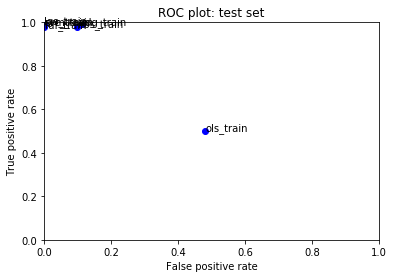

In [113]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [114]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [112]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
305
Scary man... 

Please please PLEEEEEEEEEASE don't hit me!!!! ( 94.8.193.32
* * * * * * * * * 
371
WHO YA CALLIN' A TWIT?
* * * * * * * * * 
627
REDIRECT Talk:Scooby-Doo! WrestleMania Mystery
* * * * * * * * * 
802
"See my note in the afd regarding Eduard Einstein.  I didn't say the article was too short, I said it's not noteworthy.  If you can convince me he's noteworthy, I'll be happy to withdraw.  But we don't include relatives of famous people and we don't include schizophrenics — why would we include a relative of a famous person who happened to have schizophrenia?  —  
Please stick to the facts. Speculation about people under 30, snide comments about my edits, etc., don't help determine the merit of the Eduard Einstein article. BTW - if you don't like my edits - this is Wikipedia - you can improve them as you see fit. My writing skill has no bearing on EE's noteworthiness.  
I didn't begin the speculation about Paris Hilton and her dumb dog.  It al

7614
I wash my hands, my dear. Is not that what you wanted? Well then, I will not move none finger, none hand, none arm, nothing more. Bye bye!
* * * * * * * * * 
7719
Whatsup Amortias,

One question if you not an admin,  where does your power in wiki come from. But mainly, um for the first one about kogarah, i saw it is superficial content being displayed. Second one I did because well my brother goes to Newington College and thirdly that like Brisbane wasnt actually supposed to go up. Can you remove it. Thx Nathan
* * * * * * * * * 
7751
Re: Tryptofish discussion 

I completely agree with your red pill explanation of the problem, and I think you have a good handle on the problem.  But just like in The Matrix, few people could handle going down the rabbit hole. I think Trypto felt like you were attacking him for his arbcom opinion, and he's pretty sensitive about such things.  I think you're correct about Kudpung, but there are several differert ways to make your point without directl

14842
give Chaser 
give the dude named chaser a gold start
he helped me out
* * * * * * * * * 
15014
Duel 

I challenge you to a duel. I will be allowed a tank; you a shotgun. Expect to get exactly what you deserve!
* * * * * * * * * 
15200
Paul Byrd 
Why did you undo my constructive edits to the Paul Byrd article? It is well-known that he has a pig-nose and mentions it in his book.
* * * * * * * * * 
15599
RE:talk page 

Youre welcome,
By the way, will the page be deleted, since it's uselwss now?
   TLK | Y!
* * * * * * * * * 
15874
hahaha..Am I care?? Shah
* * * * * * * * * 
16227
" LIL Wayne plans on doing a remix to the track ""Mutha Fukin Nigga"" with hot new hip hop artist Tyler Robinson"
* * * * * * * * * 
16413
we dont need to edit WP, cuz we gotz us sum good ol fashion FARPAR!!! U dont know what that iz unless u from down here...but U WILL find out, son! Nuthin u can due!!!!
* * * * * * * * * 
16544
Right what you need to understand is that we are equals you are not higher tha

29068
Added references. Let 'er rip.

Ike
* * * * * * * * * 
29515
test 

test 159.242.66.76
* * * * * * * * * 
29856
"

Your facts are wrong: I haven't identified myself as gay (or straight, for that matter).  I favour inclusion of the reference because it's an significant piece of information ... and while I don't doubt that Maddin's loss was ""disappointing"" to him, such terminology doesn't meet the standard for inclusion on this forum.   "
* * * * * * * * * 
29951
"

Just wondering if EhuangZhang = Archaic_d00d simply based on EhuangZhang's appearance at Talk:Matthew Johns following on from their ""arguing"" at Talk:Sex and intelligence and their partiality to ""coward"" references and similar line of insult:
 Are we becoming a nation of cowards?
 snivelling little coward.
 EhuangZhang's personal attack at Talk:Matthew Johns - and very first contribution to that article/talk page.

Of course, they may just be birds of a feather.  florrie  "
* * * * * * * * * 
30065
|decline=It's m

35628
I'll also add that if you do not like the truth then do not edit on Wikipedia. You can warn me a 100 times - I refuse to listen to a hypocritical admin who abuses his power and who demeans Wikipedia with his dictatorial attitude. Nobody is going to bully me around - just because you're an admin it doesn't give you the right to in any way.
* * * * * * * * * 
36002
Block me? Look buddy, you dont even come close to being an admin on this site. Try to impress someone else. Why don't you pretend to be Yanksox again?
* * * * * * * * * 
36167
"

This seems unbalanced.  whatever I have said about Mathsci, he has said far more extreme and unpleasant things about me (not to mention others), and with much greater frequency.  I'm more than happy to reign myself in, if that's what you'd like (ruth be told, I was just trying to get Mathsci to pay attention and stop being uncivil).  I would expect you to issue the same request to Mathsci.  

 If this is intentionally unbalanced (for whatever re

42755
"

If wiki was a serious endeavor then most/many of the editors/admins would be canned - I suspect Jimbo knows he has goofs on board - Fat causing the entire incineration of 1 much less millions. I know lots of fat women - men too - and I have yet to hear of even one - in all history - exploding into flame, even after death in a house... fire.  I don't know if you are trying to be humorous or if this is really their level of competence. If they can cite the fat cremation thing go ahead - their ""reliable"" sources have been called unreliable by other of their ""reliable"" sources ( when a person finds one of these they are within minutes of being banned ( it must really rancle goofs to only have the power to ban - sounds like a bunch of not too bright kids on the playground)). PS The entire structure of your history... articles smells more of propaganda than information. The Duesberg articles are particularly embarrassing - not being able to even get partway through one of his po

Sylar gets Cryokinesis from James Walker however in the episode Don't look back he has frozen James wlker's body then cut open his head.
* * * * * * * * * 
48662
"
 , your logic is flawed and shows an single mindedness to put any kind of speculation, unsubstantiated, unproven and poorly documented  charges to ""dirty up"" this article.  I will not allow you to editorialize and hide it as ""Encyclopedic"" and spin this article in to an Attack Piece. What you want is to put up very serious and damaging and all unproven allegations, speculated by a very partisan press, all happened a long time ago, and NEVER ACTED ON OR PROVEN.  YOUR logic, is in violation of a number of well established Wiki Policies, including WP:BLP WP:UNDUE WP:COAT most notable, WP:BLPSTYLE Also, this atricle will not be a long, regurgitation of all the evil you think this man did.  In the end, dump a truck load of junk, don't make it true, right, or fair.  
In closing, YOUR LEADER - JIMMY, had said this... I QUOTE...

54810
The X-Factor is Sean Waltman's signature move. Give me a few seconds, I'll watch YouTube and see if I can describe it.

few seconds pass*

As per this video, it looks like the X-Factor is simply a run of the mill sitting facebuster. He basically grabs the opponents head, jumps up, opponent jumps too, then he slams their face into the mat, in a seated position. He starts it off with a kick to the gut. Basically, the IP user would like a link to a wrestling move page, complete with a description of the move. 199.212.27.249
* * * * * * * * * 
54856
National Security 

I'm George W. Bush and this article violates national security.  Failure to eliminate it will result in criminal charges and the shutting down of Wikipedia.

  A.K.A. George W. Bush, president of the US
* * * * * * * * * 
54925
"

 {{Whos is a black israelite}} 

I see the black israelites in time square and other urban centers in Nyc and they have some type of chart of 12 countries that states who they are/ where ther

60922
Coward

Can I just ask why you would be so cowardly and delete my previous comment? Your a credit to the admin staff. 134.226.1.194
* * * * * * * * * 
61048
Eliminate article there is not curse 

The Patriots went 16-0 after losing the super bowl. And the curse hasn't been consistent (unlike the Madden Curse). The curse has only worked a few times. We should eliminate this article.
* * * * * * * * * 
61270
Better still, why don't YOU do some hard work here and make some meaningful contribution to this rather neglected article yourself? (Instead of going out of your way to find alleged faults with my contributions)
* * * * * * * * * 
61664
Waiting for a grown up non-cult member to stop you from censoring my post to protect your other cult member.
* * * * * * * * * 
61824
P.P.S. Learn to use periods and stop deleting comments that hurt your feelings '(
24.186.66.126
* * * * * * * * * 
62277
====
Hey, Nawlin, can you please refain from vandalising my discussion page? I'd appreciate 

69477
You won't back down.  Right?  You know absolutely nothing about what you edit, don't want to be educated, and prefer to hide behind Wikipedia.
* * * * * * * * * 
69771
Your problem is that you remove my criticism which are not personl attacks 

You need to actually read my messages, of which about 5 of them you removed from the record and I'm keeping yours off until you bring mine back.
* * * * * * * * * 
70024
hans beckert is one of the first serial killers on the silver screen and because of that is a  piece of history and should not be removed
* * * * * * * * * 
70067
What, I never agreed with you. You clearly know nothing about baseball or you do not understand English. I am just glad you don't live in this country because people like you don't belong. I am making your day? HAHA, you are a sad sad human being.
* * * * * * * * * 
70101
Reply
Who can read and understand this vandal herostratus anyways?
* * * * * * * * * 
70344
Dick Scanlan 4 lyfe 

Aren't you a little young to 

76480
UT
DougiePooh, It definitly WAS an attack! Don't you get snide with me!
* * * * * * * * * 
76514
Canyon Hills 

I'm sorry, I cannot do that. It'd be wrong to claim your edits as my own, as that's plagiarism to begin with. Please just sit out your arbcom ban and come back and edit constructively. Focus on other things instead of having your block extended another day each time you come back and evade it. It's obvious that you care for your community, but Wikipedia has rules about these things.
* * * * * * * * * 
76525
Oh yeah, and have I seen a word of thanks from you for my edits?
* * * * * * * * * 
76668
You have been reported, both of you 
I have reported you for harassment. Perhaps this will make you stop 93.161.107.169
* * * * * * * * * 
76748
Blocked because PeterSymonds is a Douchebag (see image)
* * * * * * * * * 
76835
editor is a vendalism boy 

108.233.85.171
* * * * * * * * * 
77031
"hey... google this term and see that US Soccer posted it on FB: ""FIFA changed the off

81254
Meters, what's the deal with you going around arbitrarily deciding whether or not something's allowed on the talk page? 
What are you, some kind of wiki dictator who just deletes something you don't like? What wiki rule did I just violate when I question whether or not Diem was a homosexual dictator? 71.129.62.14
* * * * * * * * * 
81719
For God's sake... 

Why can't everyone agree on something?
* * * * * * * * * 
81742
RE: your head page...!
LOL!
* * * * * * * * * 
81816
"

 Please stop defending pedophilia on MY talk page.  

If you like it so much, this is the place. Live it up and I'll ignore you. Hopefully the cops won't. Leave it the hell off my talk page, it's disgusting.  — Preceding unsigned comment added by  (talk • contribs)  "
* * * * * * * * * 
82005
Personal attack and baiting by Crockspot noted.
* * * * * * * * * 
82060
Hypocrisy 

If I removed everything that doesn't have a source on WP, there goes half your site! Ironic! But the sad thing is, it's sourced to nume

89645
6: Do not EVER edit my rules.
* * * * * * * * * 
89683
First of all , Welcome back. Second, You are the one who started this debate. I told you to simply stop putting irrelevant comments in the summary. And then you get all tough and defensive and start a political debate with me. Third, no sir, I've edited plenty of Iranian articles. Only you seem to disagree with me. Are you the truth because you listen to Iranian Media? How bout this, I take you to Iran and show you what the country is really like, Im at an advantage since my family is from a war zone and a rural area, not just the flashy capital, then you can come back and argue your idiotic conspiracy theories to me.
* * * * * * * * * 
89773
Who on earth said I was a man?
* * * * * * * * * 
90707
push comes to shove is not in the disog
* * * * * * * * * 
90829
calm down

Seriously, man, you are beginning to scare me. What's with all the high drama and blustering? An ANI report? Why? What for? Perhaps you should take a health

101683
Please stop reverting 

You have convinced me. Such removal may constitute vandalism. You have fought hard to convince me, and now see to be backing off. What gives?
* * * * * * * * * 
101973
)

It all begins in Resident Evil Zero(If you have played it
* * * * * * * * * 
101984
Thanks Peridon 86.176.170.210
* * * * * * * * * 
102206
SCOTT YOU ARSE YOUR PROFILES ON THE WRONG BLOODY PAGE

SIGNED JAMES
* * * * * * * * * 
102293
"
Um... TP, am I blocked?  (TALK) "
* * * * * * * * * 
102377
I can't believe some is willing to throw away their entire life on wikipedia.  it's really, really, really, really, really sad
* * * * * * * * * 
102476
So how does a person learn about Hardcore Punk characteristics with any of that. They ''Don't'.~~~~
* * * * * * * * * 
102478
We're not going to do your homework for you.
* * * * * * * * * 
102775
You think you're smarter than NATO??? or Romanian Gov.???
* * * * * * * * * 
102865
Your appeal 

But Wikipedia is more than a website. We share a commo

111263
Then considering that no independent expert, no one without an interest in not being responsible for having blown up children, you agree it is ridiculous for us to place the killers denial on par with those experts who pulled pieces of Israel bombs out of the victims.
* * * * * * * * * 
111553
"

 Ah ha now you have a barnstar you have to put it in your award Section =D. (Talk)  "
* * * * * * * * * 
111650
"
That's not me, and looks like you are the one doing the harassing, by adding that smiley face. Seek his grace "
* * * * * * * * * 
111682
"

did you just call me ""stupid"". I cannot believe this. You block people for personal attacks and then you just come at them.  THis is totally relevant.   JohnHistory"
* * * * * * * * * 
111694
Lighten up dude, I wasn't insinuating that you are a sock. I don't even know you.
* * * * * * * * * 
111917
Mr. hhh pedigree please leave my page alone.... Rockin Rebel you have no merit or wrestling experiance in this business like me....please 

115464
"WJ didn't perform at the WMA because he can't sing at all anymore. That is the real reason he hasn't toured for a decade, along with his bankruptcy. Even his vocals on ""We've Had Enough"" four years ago were poor and he never had a strong voice to begin with, certainly not comparable with the real King, Elvis Presley. Jackson has had financial problems since at least 1998 due to his declining sales and popularity, as well as his inactivity and having to support an entire family - not just those three children who aren't his biologically. In 2002 it was revealed he was in debt to various international banks to the tune of tens of millions of dollars, and after losing those lawsuits in May 2003 he was confirmed as on the verge of bankuptcy with debts of $400 million. Invincible was a flop because it sold less than a third of his last album, ""Dangerous"", and it was all crap. 99% of Jackson's few remaining fans regard it as his worst album. In 1989 Jackson made it known he had t

125204
Are you sure you are a Kurd 

Sorry, but I think you are manioulating this website. It is funny how you focus on Iran. WHy do you not discuss Turkey and the terrible things they do to Kurds there. I think I know why.
* * * * * * * * * 
125392
I don't know anymore. I lost all sources after being burned-out. Feel free to change it. Maybe some day I'll get back to this article. At the moment, most of my energy is wasted on RfCs and other crap.
* * * * * * * * * 
125555
What A Bunch Of Kykes, Always Trying To Rule The World
* * * * * * * * * 
125718
You have the option to ignore it at your own peril, even get further angry at me and try to act more destructive in vengeance (which I hv seen you with other editors), but again none of this is going to improve your life. Please cast your ego aside, take a break from WP for few months, refocus on your life, resolve all those issues, come back as a HAPPY and CONSTRUCTIVE ADMIN (who creates, not destroy, who leaves positive pshycological f

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [115]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1659, 'TN': 15022, 'FP': 13639, 'FN': 1595, 'Accuracy': 0.522669591101363, 'Precision': 0.10844554843770428, 'Recall': 0.5098340503995082, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [116]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2119, 'TN': 27200, 'FP': 1461, 'FN': 1135, 'Accuracy': 0.9186589378035407, 'Precision': 0.5918994413407821, 'Recall': 0.6511985248924401, 'desc': 'svm_test'}


### MODEL: logistic regression

In [117]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2114, 'TN': 27133, 'FP': 1528, 'FN': 1140, 'Accuracy': 0.9164029453235156, 'Precision': 0.5804503020318507, 'Recall': 0.6496619545175168, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [118]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2112, 'TN': 23821, 'FP': 4840, 'FN': 1142, 'Accuracy': 0.812564624784584, 'Precision': 0.3037974683544304, 'Recall': 0.6490473263675476, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [119]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2103, 'TN': 27186, 'FP': 1475, 'FN': 1151, 'Accuracy': 0.9177189409368636, 'Precision': 0.5877585243152599, 'Recall': 0.6462814996926859, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [120]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 3078, 'TN': 23928, 'FP': 4733, 'FN': 176, 'Accuracy': 0.8461851793827354, 'Precision': 0.3940596594546153, 'Recall': 0.9459127228027043, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [121]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1190, 'TN': 28608, 'FP': 53, 'FN': 2064, 'Accuracy': 0.9336675544414852, 'Precision': 0.9573612228479486, 'Recall': 0.36570374923171484, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

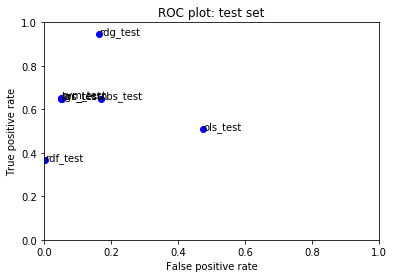

In [122]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [123]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_test.csv', my_random_seed=337, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                  id                                       comment_text
0   00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1   0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2   00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3   00017563c3f7919a  :If you have a look back at the source, the in...
4   00017695ad8997eb          I don't anonymously edit articles at all.
5   0001ea8717f6de06  Thank you for understanding. I think very high...
6   00024115d4cbde0f  Please do not add nonsense to Wikipedia. Such ...
7   000247e83dcc1211                   :Dear god this site is horrible.
8   00025358d4737918  " \n Only a fool can believe in such numbers. ...
9   00026d1092fe71cc  == Double Red

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [125]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.34213653338904704


In [126]:
raw_data.head()

id                                       comment_text  \
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...   
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...   
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...   
3  00017563c3f7919a  :If you have a look back at the source, the in...   
4  00017695ad8997eb          I don't anonymously edit articles at all.   

   word_count  punc_count  exclam_count  
0          72          10             0  
1          13           1             0  
2          16           0             0  
3          38           3             0  
4           7           1             0

In [127]:
my_submission.head()

id  prediction
0  00001cee341fdb12        True
1  0000247867823ef7       False
2  00013b17ad220c46       False
3  00017563c3f7919a       False
4  00017695ad8997eb       False

In [128]:
my_submission.shape

(153164, 2)

In [129]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation